In [14]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
from scipy.spatial.distance import cdist
import src.tools as tools
from Bio import Phylo
from src.coevolution import * 

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

# build_stop_codon_dataset(arf1_df.genome_id.unique())
stop_codon_df = pd.read_csv('../data/stop_codon_genome_metadata.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count

In [16]:

# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers

masks = dict()
masks['pyl+ recoded'] = (arf1_df.tag_percent < 0.05) & (arf1_df.has_pyl)
masks['pyl+'] = (arf1_df.tag_percent >= 0.05) & (arf1_df.has_pyl)
masks['pyl-'] = (~arf1_df.has_pyl)

categories = list(masks.keys())
arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')

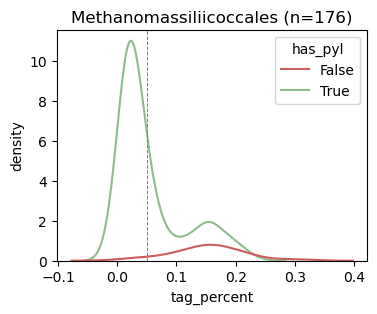

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))

stop_codons = ['TAA', 'TGA', 'TAG']
palette = {True:'darkseagreen', False:'indianred'}

figure_df = arf1_df.copy()
figure_df = figure_df[figure_df.order == 'Methanomassiliicoccales'].copy()
sns.kdeplot(figure_df, x='tag_percent', hue='has_pyl', palette=palette)
ax.set_ylabel('density')
ax.axvline(x=0.05, ls='--', color='gray', lw=0.7)
ax.set_title(f'Methanomassiliicoccales (n={len(figure_df)})')

plt.show()

# Among Pyl+ archaea, when the TAG content drops below 5%, the extension length spikes. This seems like a reasonable threshold for 
# choosing organisms which might have aRF1 changes. 
 
# When the TAG content is higher, the extension lengths are generally lower. In this scenario, we might not expect the 
# release factor to look very different. Genomes are robust to Pyl incorporation and stop codon readthrough. 

# When the TAG content is lower, extension lengths are higher. In these genomes, it may
# be the case that the genomes have fully adapted to frequent Pyl; these are probably the "recoded" genomes.

In [18]:
arf1_df = arf1_df[arf1_df.order == 'Methanomassiliicoccales'].copy()
FASTAFile().from_df(arf1_df).write('../data/methanomassiliicoccales_arf1.fa')
print(f'Removing all non-Methanomassiliicoccales organisms from the DataFrame. {len(arf1_df)} sequences remaining.')

styles = {id_:'bold' for id_ in arf1_df[arf1_df.has_pyl].index}
sizes = {id_:2 for id_ in arf1_df[arf1_df.has_pyl].index}
tools.make_itol_annotation_file(arf1_df, field='tag_percent', path='../data/methanomassiliicoccales_arf1_annotation_tag_percent.txt', styles=styles, sizes=sizes)

palette = {'pyl+ recoded':darkgreen, 'pyl-':red, 'pyl+':lightblue}
tools.make_itol_annotation_file(arf1_df, field='category', path='../data/methanomassiliicoccales_arf1_tree_annotation_category.txt', palette=palette)

Removing all non-Methanomassiliicoccales organisms from the DataFrame. 176 sequences remaining.


In [19]:
index, alignment = load_msa(path='../data/methanomassiliicoccales_arf1.afa', ids=arf1_df.index) # Should load the sequences from Methanosarcinales only. 
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['has_pyl'] = arf1_df.has_pyl
alignment_df['category'] = arf1_df.category

seq = ''.join(alignment[0])
domain_boundaries = get_domain_boundaries(seq)

get_domain_boundaries: NIKS boundaries 57-61.
get_domain_boundaries: YxCxxxF boundaries 121-128.
get_domain_boundaries: GTS boundaries 25-28.


In [20]:
def plot_scores_2d(scores:np.ndarray, start=0, stop=150, ax:plt.Axes=None):
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])
    plt.imshow(scores[start:stop, start:stop], cmap=cmap)
    ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_xticks(np.arange(start, stop), labels=np.arange(start, stop), fontsize='x-small')


def plot_scores_1d(scores:np.ndarray, start=0, stop=150, y_label:str='', ax:plt.Axes=None, color:str='steelblue'):
    scores = scores[start:stop]
    sns.lineplot(x=np.arange(len(scores)), y=scores, ax=ax, color=color)
    ax.set_xticks(np.arange(len(scores)), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_xlim(xmin=start, xmax=stop)
    ax.set_ylabel(y_label)

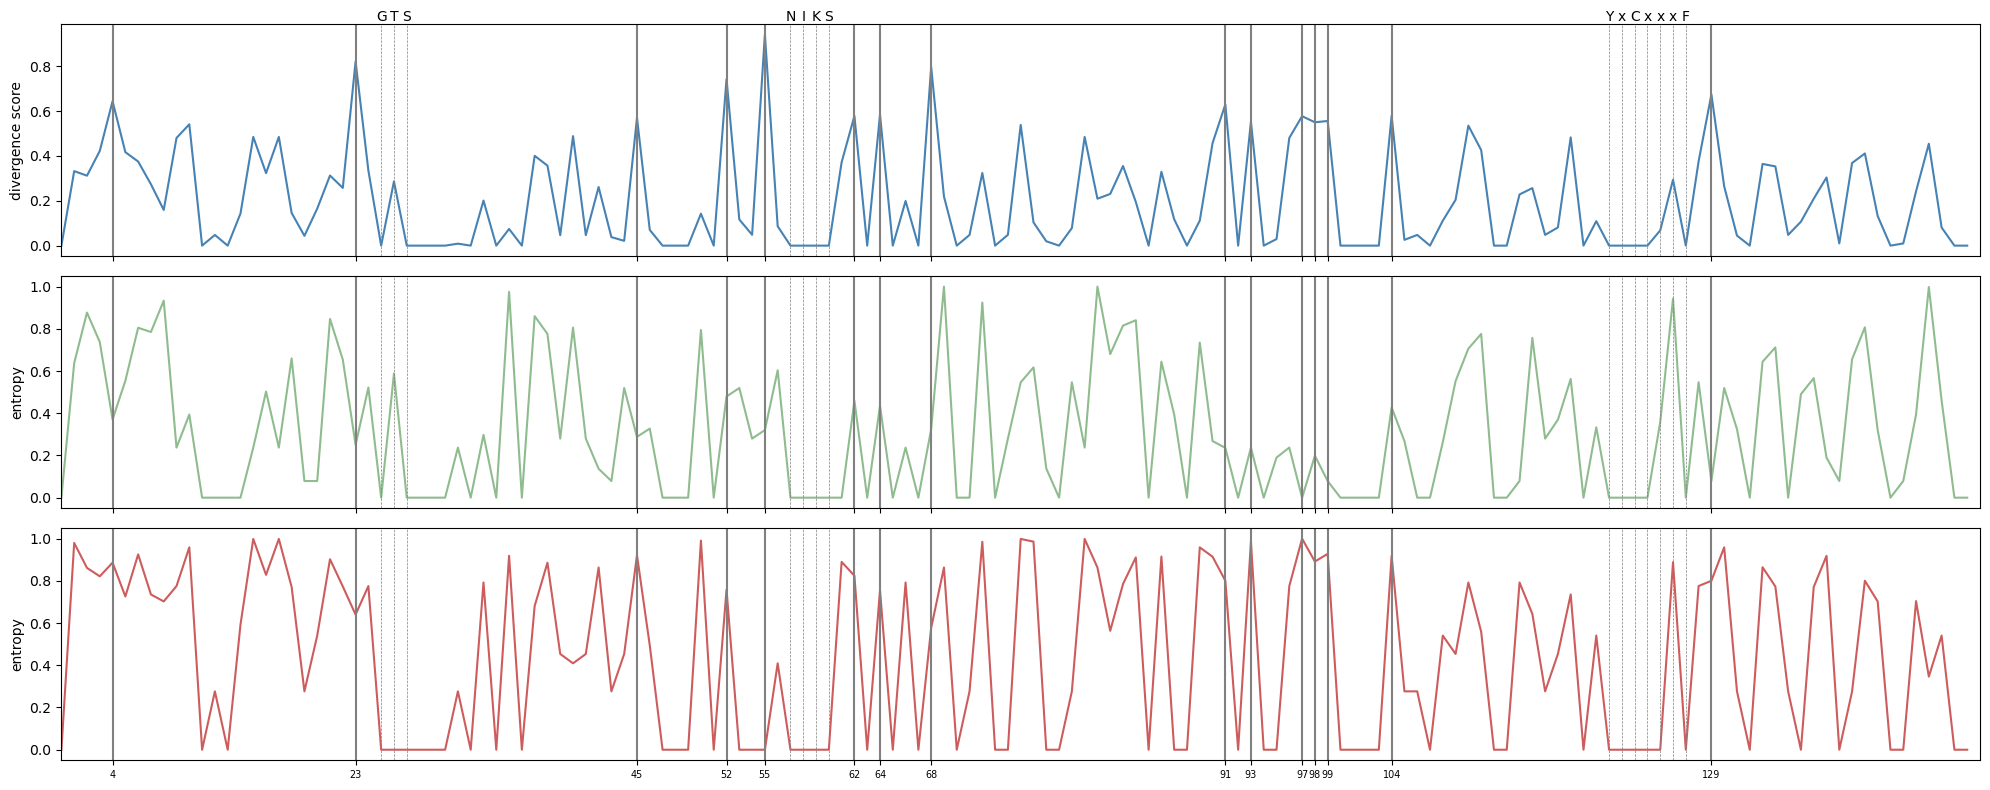

In [21]:
def annotate_residues(annotations:dict, ax=None, lines_only:bool=False):
    for seq, (start, stop) in annotations.items():
        positions = np.arange(start, stop)
        for x, aa in zip(positions, list(seq)):
            if not lines_only:
                ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
            ax.axvline(x, ls='--', lw=0.5, color='gray')


figure_df = alignment_df.copy()
figure_df = figure_df[figure_df.category.isin(['pyl+ recoded', 'pyl-'])]

fig, (ax_a, ax_b, ax_c) = plt.subplots(figsize=(20, 8), nrows=3, sharex=True)

divergence_scores = get_scores(figure_df)
plot_scores_1d(divergence_scores, ax=ax_a, y_label='divergence score')
markers = np.argsort(divergence_scores[:150])[::-1][:15]

plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl+ recoded'])[0], ax=ax_b, y_label='entropy', color='darkseagreen')
plot_scores_1d(get_entropies(figure_df[figure_df.category == 'pyl-'])[0], ax=ax_c, y_label='entropy', color='indianred')

annotate_residues(domain_boundaries, ax=ax_a)
annotate_residues(domain_boundaries, ax=ax_b, lines_only=True)
annotate_residues(domain_boundaries, ax=ax_c, lines_only=True)

# for x in markers:
for ax in [ax_a, ax_b, ax_c]:
    for x in markers:
        ax.axvline(x, ls='-', color='gray')
ax_c.set_xticks(markers, labels=markers)

fig.tight_layout()
plt.show()



Generating plots for 15 positions.


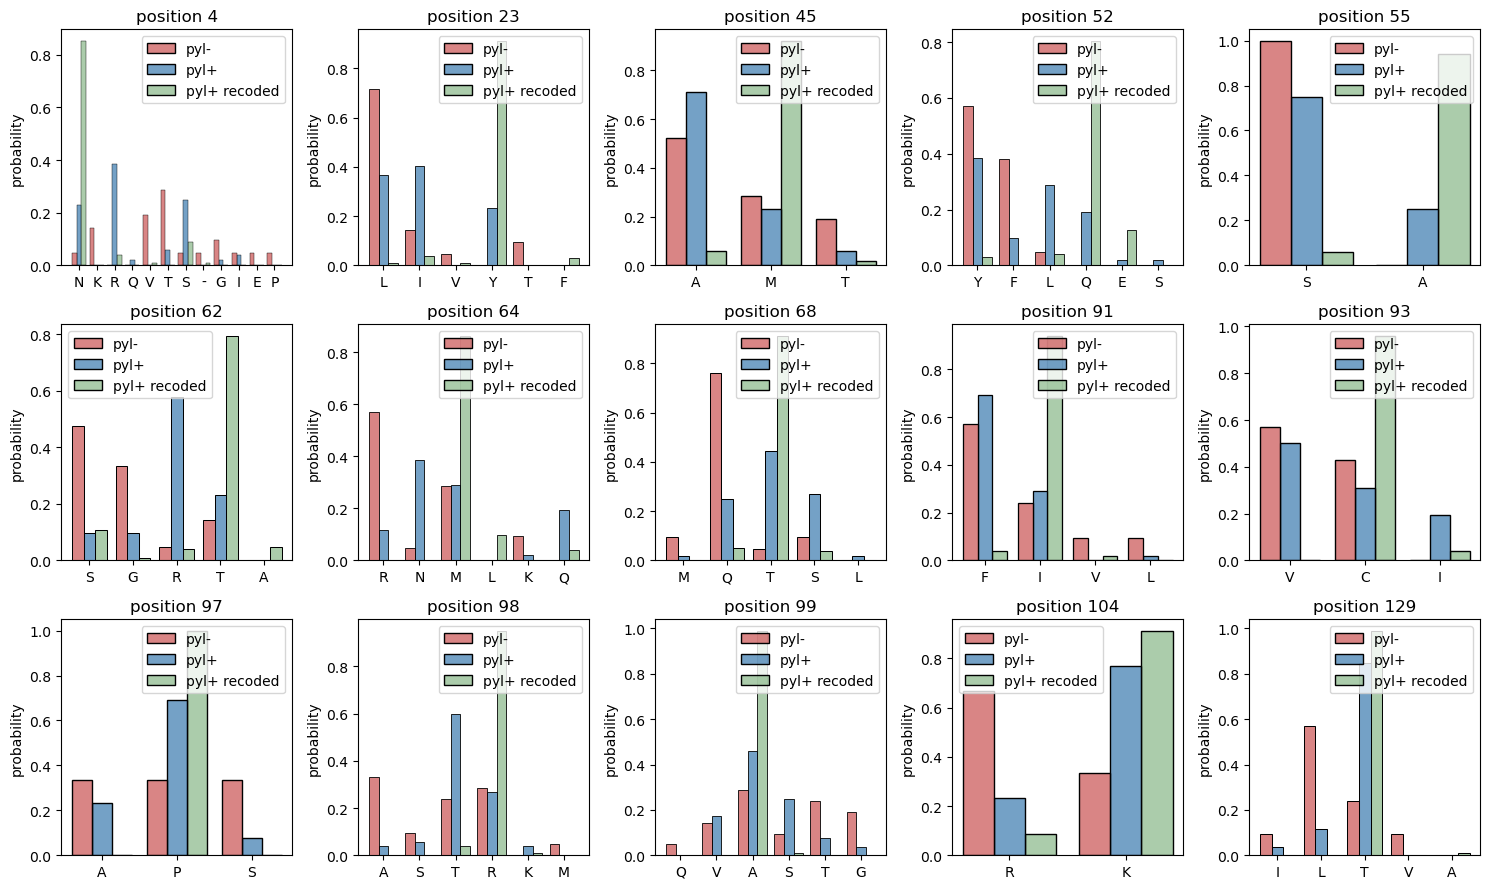

In [22]:
positions = sorted(markers)
print(f'Generating plots for {len(positions)} positions.')

figure_df = alignment_df.copy()
figure_df['category'] = arf1_df.category 

palette = {'pyl+ recoded':'darkseagreen', 'pyl+':'steelblue', 'pyl-':'indianred'}

n_rows = 3 
n_cols = 5

fig, axes = plt.subplots(figsize=(3 * n_cols, 3 * n_rows), nrows=n_rows, ncols=n_cols)
for ax, position in zip(axes.ravel(), positions):
    plot_residue_counts(figure_df, position=position, ax=ax, hue='category', palette=palette)
fig.tight_layout()
plt.show()

In [23]:
# No single signal, but perhaps if you look at the second-order scores, i.e. distribution of residue pairs?
# Worried about the mutual information metric, as it can be easily skewed by a single outlier